In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy

import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import seaborn as sns

In [11]:
%matplotlib inline

In [3]:
ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historical/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-diff_Oyr_CanESM2_historical_r1i1p1_1861-1880_1986-2005.nc'

In [6]:
ohc_cube = iris.load_cube(ohc_file, 'ocean heat content')
coord_names = [coord.name() for coord in ohc_cube.dim_coords]

In [7]:
coord_names

['depth', 'latitude', 'longitude']

In [58]:
ohc_cube.coord('depth')[-1]

DimCoord(array([5233.29980469]), bounds=array([[5038.        , 5428.59960938]]), standard_name='depth', units=Unit('m'), long_name='ocean depth coordinate', var_name='lev', attributes={'positive': 'down'})

## Depth plot

In [8]:
depth_cube = ohc_cube.collapsed(coord_names[1:], iris.analysis.SUM)

In [29]:
def make_grid(depth_values):
    """Make a dummy cube with desired grid."""
       
    depth = iris.coords.DimCoord(depth_values,
                                 standard_name='depth',
                                 units='m',
                                 long_name='ocean depth coordinate',
                                 var_name='lev')

    dummy_data = numpy.zeros(len(depth_values))
    new_cube = iris.cube.Cube(dummy_data, dim_coords_and_dims=[(depth, 0)])

    new_cube.coord('depth').guess_bounds()

    return new_cube


def regrid(cube, ref_cube):
    """Regrid to reference grid, preserving the data sum"""

    depth_bounds = cube.coord('depth').bounds
    depth_diffs = numpy.apply_along_axis(lambda x: x[1] - x[0], 1, depth_bounds)
    cube_scaled = cube / depth_diffs

    ref_points = [('depth', ref_cube.coord('depth').points)]
    cube_regridded = cube_scaled.interpolate(ref_points, iris.analysis.Linear())         

    ref_depth_bounds = ref_cube.coord('depth').bounds
    ref_depth_diffs = numpy.apply_along_axis(lambda x: x[1] - x[0], 1, ref_depth_bounds)
    new_cube = cube_regridded * ref_depth_diffs

    return new_cube

In [42]:
new_grid = make_grid(numpy.arange(1, 5500, 2))

In [43]:
new_depth_cube = regrid(depth_cube, new_grid)

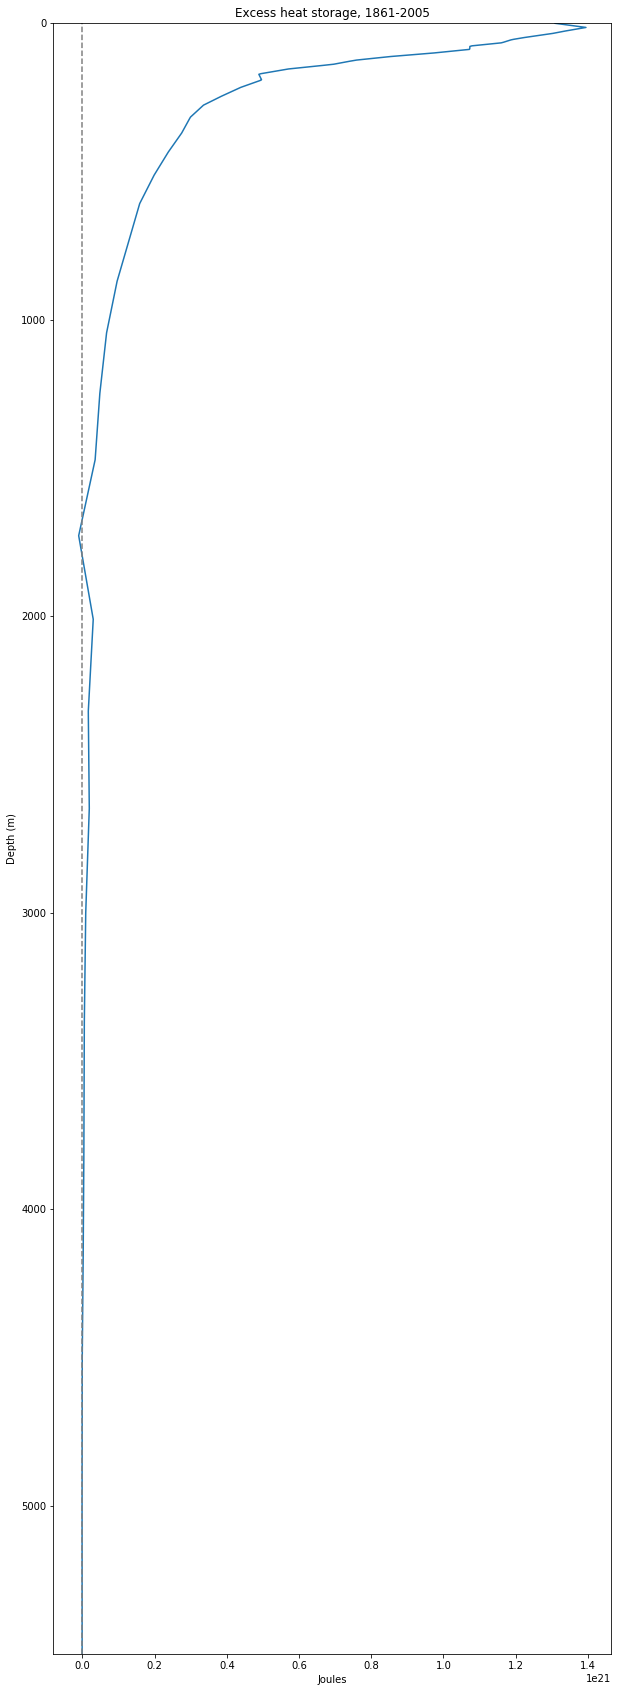

In [57]:
fig = plt.figure(figsize=[10, 30])

new_ydata = new_depth_cube.coord('depth').points
new_xdata = new_depth_cube.data

plt.plot(new_xdata, new_ydata)
plt.gca().invert_yaxis()

plt.ylim([5500, 0])
#plt.xlim([-0.1e21, 0.2e21])

plt.axvline(0, color='0.5', linestyle='dashed')
plt.xlabel('Joules')
plt.ylabel('Depth (m)')
plt.title('Excess heat storage, 1861-2005')
plt.show()

In [46]:
depth_cube.data.sum()

1.960041582632171e+23

In [47]:
new_depth_cube.data.sum()

1.969651548083772e+23